## Анализ данных Titanic: SQL-запросы и визуализации

В этом ноутбуке мы проводим исследовательский анализ данных (EDA) на примере пассажиров Титаника с помощью SQL-запросов и визуализации результатов.

In [2]:
import os
from pathlib import Path
from dotenv import load_dotenv
import psycopg2

load_dotenv()


True

In [3]:
# Берём переменные из .env
DB_HOST = os.getenv("POSTGRES_HOST")
DB_PORT = os.getenv("POSTGRES_PORT")
DB_NAME = os.getenv("POSTGRES_DB")
DB_USER = os.getenv("POSTGRES_USER")
DB_PASSWORD = os.getenv("POSTGRES_PASSWORD")


In [4]:
def get_db_connection():
    if None in (DB_HOST, DB_PORT, DB_NAME, DB_USER):
        raise ValueError("Одна из переменных окружения не задана!")
    conn = psycopg2.connect(
        host=DB_HOST,
        port=DB_PORT,
        dbname=DB_NAME,
        user=DB_USER,
        password=DB_PASSWORD
    )
    return conn

conn = get_db_connection()

In [5]:
# выполним простой запрос для проверки соединения
sql_query = """
    -- общее количество пассажиров
    SELECT COUNT(*) AS total_passengers
    FROM titanic.titanic;
"""

with conn.cursor() as cur:
    cur.execute(sql_query)
    result = cur.fetchone()
    print(f"Result: {result[0]} passengers found.")
    

Result: 891 passengers found.


In [6]:
import matplotlib.pyplot as plt
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'petroff10', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
sns.set_style("darkgrid")    # стиль графиков
sns.set_context("notebook")  # масштаб и шрифты
sns.set(font_scale=1.1)      # размер шрифта


In [9]:
query = """
-- общее количество выживших и погибших
    select
    titanic."Survived",
    count(*) as count
    from titanic.titanic
    group by titanic."Survived";
"""

C:\Users\Акылай\AppData\Local\Temp\ipykernel_20424\1280790737.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_survival = pd.read_sql_query(query, conn)
C:\Users\Акылай\AppData\Local\Temp\ipykernel_20424\1280790737.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Survived", y="count", data=df_survival, palette=["salmon", "lightblue"])


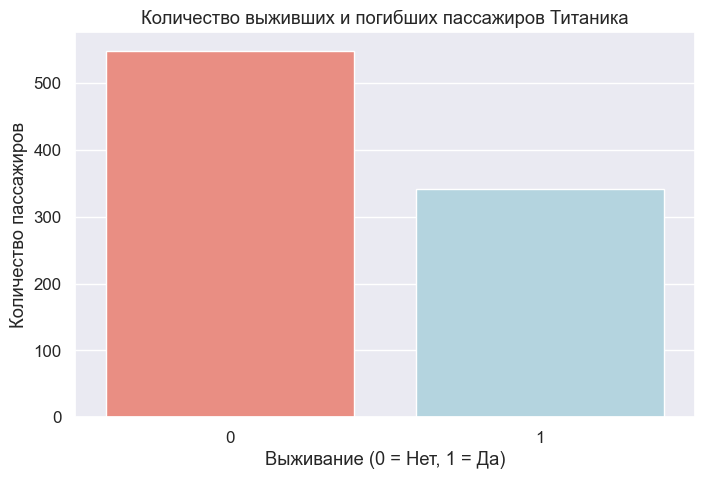

In [10]:
df_survival = pd.read_sql_query(query, conn)
plt.figure(figsize=(8, 5))          
sns.barplot(x="Survived", y="count", data=df_survival, palette=["salmon", "lightblue"])
plt.title("Количество выживших и погибших пассажиров Титаника")
plt.xlabel("Выживание (0 = Нет, 1 = Да)")
plt.ylabel("Количество пассажиров")
plt.show()

In [11]:
query = """
-- Судьба самых пьяных пассажиров
select
    t."PassengerId",
    t."Survived",
    sum(p.amount) as alcohol_spend
from titanic.purchases p
join titanic.titanic t
    on p."PassengerId" = t."PassengerId"
where p.category = 'alcohol'
group by t."PassengerId", t."Survived"
order by alcohol_spend desc
limit 20;
"""


C:\Users\Акылай\AppData\Local\Temp\ipykernel_20424\147192876.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_alcohol = pd.read_sql_query(query, conn)


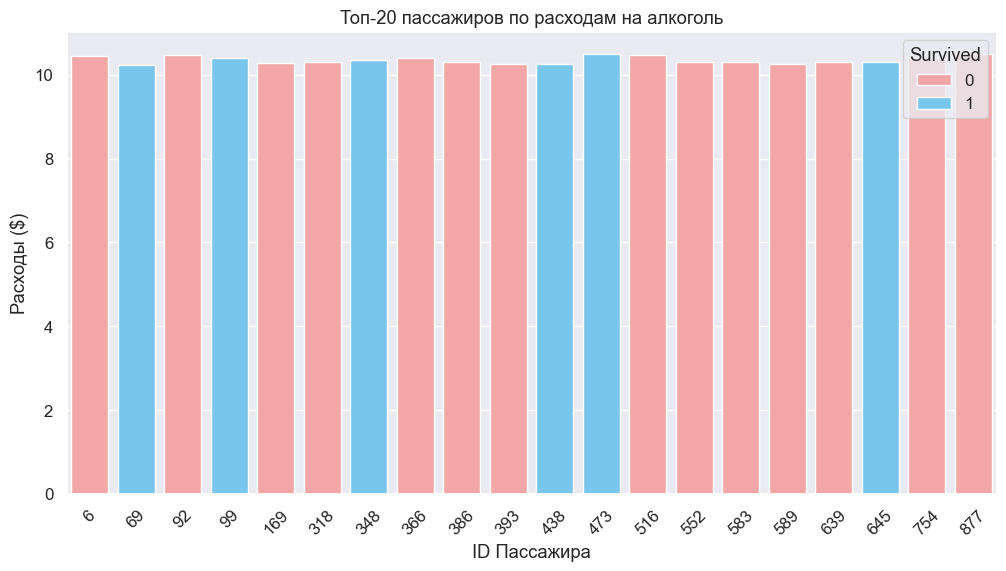

In [12]:
df_alcohol = pd.read_sql_query(query, conn)
# Топ-20 по расходам
df_top20 = df_alcohol.sort_values("alcohol_spend", ascending=False).head(20)
plt.figure(figsize=(12,6))
sns.barplot(
    x="PassengerId",
    y="alcohol_spend",
    hue="Survived",
    data=df_top20,
    palette={0: "#FF9999", 1: "#66CCFF"},
    dodge=False  # столбцы сливаются по PassengerId
    )
plt.title("Топ-20 пассажиров по расходам на алкоголь")
plt.xlabel("ID Пассажира")
plt.ylabel("Расходы ($)")
plt.xticks(rotation=45)
plt.show()




На графике показаны **топ-20 пассажиров по расходам на алкоголь**.  

- **Цвет столбца** показывает, выжил пассажир или нет:  
  - Красный (#FF9999) — не выжил (0) ❌  
  - Синий (#66CCFF) — выжил (1) ✅  
- **Символ над столбцом** также указывает на выживание:  
  - ✅ = выжил (1)  
  - ❌ = не выжил (0)  
- **Ось X** — ID пассажира  
- **Ось Y** — сумма расходов на алкоголь в $  

In [13]:
query = """--топ 10 пассажиров с их информацией
select
    t."Name",
    t."Pclass",
    t."Survived",
    sum(p.amount) as total_spend
from titanic.titanic t
left join titanic.purchases p
    on t."PassengerId" = p."PassengerId"
group by t."Name", t."Pclass", t."Survived"
order by total_spend desc
limit 10; 
"""
df_top10 = pd.read_sql_query(query, conn)
df_top10

C:\Users\Акылай\AppData\Local\Temp\ipykernel_20424\1680089809.py:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_top10 = pd.read_sql_query(query, conn)


,Name,Pclass,Survived,total_spend
0,"Stone, Mrs. George Nelson (Martha Evelyn)",1,1,None
1,"Karaic, Mr. Milan",3,0,None
2,"Natsch, Mr. Charles H",1,0,None
3,"Turcin, Mr. Stjepan",3,0,None
4,"Carrau, Mr. Francisco M",1,0,None
5,"Plotcharsky, Mr. Vasil",3,0,None
6,"Stanley, Miss. Amy Zillah Elsie",3,1,None
7,"Rothes, the Countess. of (Lucy Noel Martha Dye...",1,1,None
8,"Backstrom, Mrs. Karl Alfred (Maria Mathilda Gu...",3,1,None
9,"Barber, Miss. Ellen ""Nellie""",1,1,None


In [15]:
query = """--поле в котором пропусков больше всего
select column_name, null_count
from (
    select 'PassengerId' as column_name, count(*) filter (where "PassengerId" is null) as null_count from titanic.titanic
    union all
    select 'Survived',count(*) filter (where "Survived" is null) from titanic.titanic
    union all
    select 'Pclass',count(*) filter (where "Pclass" is null) from titanic.titanic
    union all
    select 'Name',count(*) filter (where "Name" is null) from titanic.titanic
    union all
    select 'Sex',count(*) filter (where "Sex" is null) from titanic.titanic
    union all
    select 'Age',count(*) filter (where "Age" is null) from titanic.titanic
    union all
    select 'SibSp',count(*) filter (where "SibSp" is null) from titanic.titanic
    union all
    select 'Parch',count(*) filter (where "Parch" is null) from titanic.titanic
    union all
    select 'Ticket',count(*) filter (where "Ticket" is null) from titanic.titanic
    union all
    select 'Fare',count(*) filter (where "Fare" is null) from titanic.titanic
    union all
    select 'Cabin',count(*) filter (where "Cabin" is null) from titanic.titanic
    union all
    select 'Embarked',count(*) filter (where "Embarked" is null) from titanic.titanic) t
order by null_count desc
limit 1;
"""



In [14]:
titanic_df = pd.read_sql_query("SELECT * FROM titanic.titanic;", conn)
null_counts = titanic_df.isnull().sum()
print("\nПропуски по колонкам:\n", null_counts)
most_null = null_counts.idxmax()
print("Больше всего пропусков в поле:", most_null)

C:\Users\Акылай\AppData\Local\Temp\ipykernel_20424\1342759037.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  titanic_df = pd.read_sql_query("SELECT * FROM titanic.titanic;", conn)



Пропуски по колонкам:
 PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin            0
Embarked         0
dtype: int64
Больше всего пропусков в поле: Age


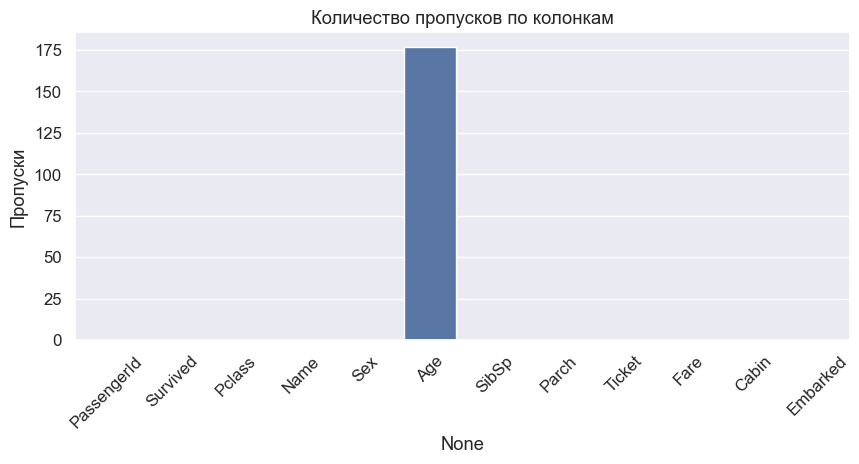

In [16]:
plt.figure(figsize=(10,4))
sns.barplot(x=null_counts.index, y=null_counts.values)
plt.xticks(rotation=45)
plt.title("Количество пропусков по колонкам")
plt.ylabel("Пропуски")
plt.show()

In [96]:
query = """--Количество выживших пассажиров которые не сделали ни одной покупки
select COUNT(*) as survived_no_purchase
from  titanic.titanic t
left join titanic.purchases p on t."PassengerId" = p."PassengerId"
where t."Survived" = 1
  and p."PassengerId" is null;
"""
df_alcohol = pd.read_sql_query(query, conn)
df_alcohol

C:\Users\Акылай\AppData\Local\Temp\ipykernel_18660\1948150448.py:8: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_alcohol = pd.read_sql_query(query, conn)


,survived_no_purchase
0,5


In [115]:
query = """--Средняя сумма затраченная по категориям класс и пол
select
    t."Sex",
    t."Pclass",
round(avg(p.amount), 2) as avg_spend
from titanic.titanic t
left join titanic.purchases p
    on t."PassengerId" = p."PassengerId"
group by t."Sex", t."Pclass"
order by t."Sex", t."Pclass";
"""
df_avg_spend = pd.read_sql_query(query, conn)
df_avg_spend

C:\Users\Акылай\AppData\Local\Temp\ipykernel_18660\470518688.py:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_avg_spend = pd.read_sql_query(query, conn)


,Sex,Pclass,avg_spend
0,female,1,5.88
1,female,2,5.81
2,female,3,5.54
3,male,1,5.85
4,male,2,5.70
5,male,3,5.83


C:\Users\Акылай\AppData\Local\Temp\ipykernel_18660\3980875638.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_avg_spend = pd.read_sql_query(query, conn)


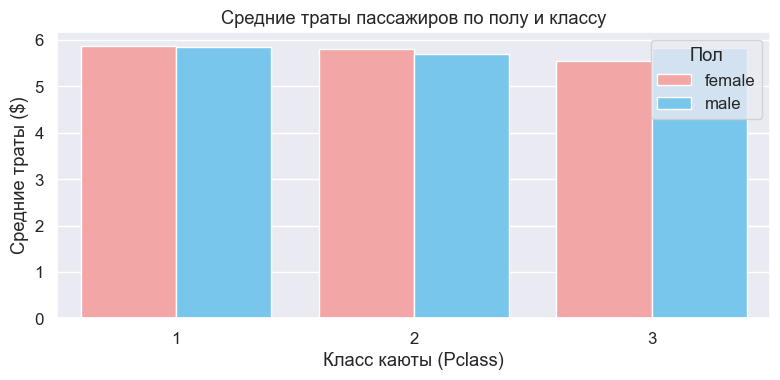

In [ ]:
df_avg_spend = pd.read_sql_query(query, conn)

# Переименуем колонку для графика
df_avg_spend = df_avg_spend.rename(columns={"avg_spend": "total_spend"})

# График
plt.figure(figsize=(8,4))
sns.barplot(
    x='Pclass',
    y='total_spend',
    hue='Sex',
    data=df_avg_spend,  # <- важно указать DataFrame
    palette={'male':'#66CCFF','female':'#FF9999'}
    )

plt.title("Средние траты пассажиров по полу и классу")
plt.xlabel("Класс каюты (Pclass)")
plt.ylabel("Средние траты ($)")
plt.legend(title="Пол")
plt.tight_layout()
plt.show()

In [117]:
query = """--Рассчет для каждого пассажира с категориями по тратам
with total_spend_per_passenger as (
select
     t."PassengerId",
     sum(p.amount) as total_spend
  from titanic.titanic t
    left join titanic.purchases p
      on t."PassengerId" = p."PassengerId" 
    group by t."PassengerId")
select
"PassengerId",
 total_spend,
    case
        when total_spend is null then 'no_spend'
        when total_spend < 30 then 'low_spend'
        when total_spend < 50 then 'medium_spend'
        else 'high_spend'
    end as spend_segment
from total_spend_per_passenger
order by total_spend desc nulls last;
"""
df_spend_segment = pd.read_sql_query(query, conn)
df_spend_segment

C:\Users\Акылай\AppData\Local\Temp\ipykernel_18660\744585379.py:22: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_spend_segment = pd.read_sql_query(query, conn)


,PassengerId,total_spend,spend_segment
0,234,54.82,high_spend
1,648,51.21,high_spend
2,6,50.05,high_spend
3,521,49.54,medium_spend
4,484,46.34,medium_spend
...,...,...,...
886,190,NaN,no_spend
887,607,NaN,no_spend
888,481,NaN,no_spend
889,385,NaN,no_spend


C:\Users\Акылай\AppData\Local\Temp\ipykernel_18660\2027195794.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


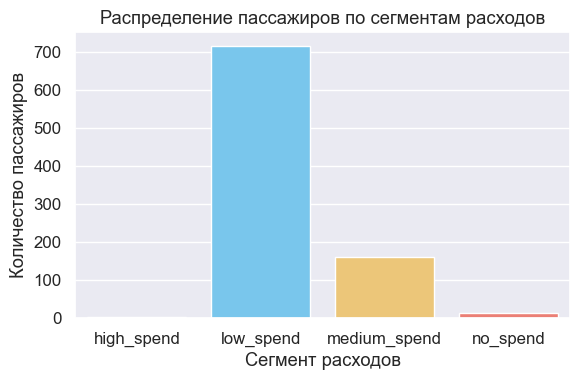

In [128]:
plt.figure(figsize=(6,4))
sns.barplot(
    x='spend_segment',
    y='count',
    data=df_spend_segment.groupby('spend_segment').size().reset_index(name='count'),
    palette=['#B0BEC5', '#66CCFF', '#FFCC66', '#FF6F61']
)

plt.title("Распределение пассажиров по сегментам расходов")
plt.xlabel("Сегмент расходов")
plt.ylabel("Количество пассажиров")

plt.tight_layout()
plt.show()

In [132]:
query = """--категория покупок и их количество с общей суммой
select category,
COUNT(*) AS num_purchases,
SUM(amount) AS total_amount
from titanic.purchases
group by category;
"""
df_categories = pd.read_sql_query(query, conn)
df_categories

C:\Users\Акылай\AppData\Local\Temp\ipykernel_18660\2749981190.py:8: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_categories = pd.read_sql_query(query, conn)


,category,num_purchases,total_amount
0,food,698,2619.21
1,alcohol,336,2389.50
2,extra_service,337,2664.50
3,other,1736,10263.47


C:\Users\Акылай\AppData\Local\Temp\ipykernel_18660\713518399.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='category', y='total_amount', data=df_categories, palette='Oranges_r')


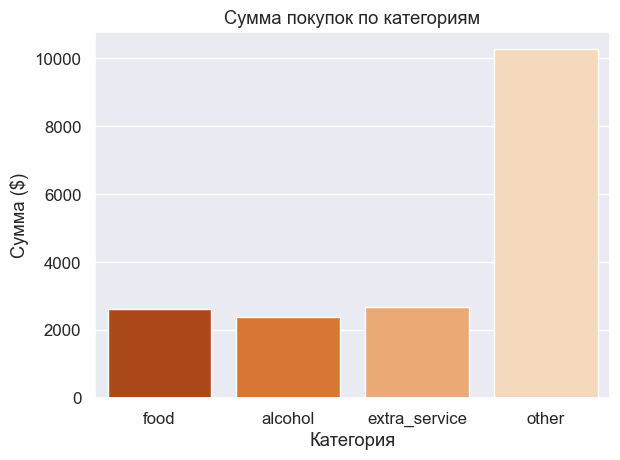

In [155]:

#  Общая сумма покупок по категориям
plt.subplot(1,1,1)
sns.barplot(x='category', y='total_amount', data=df_categories, palette='Oranges_r')
plt.title("Сумма покупок по категориям")
plt.xlabel("Категория")
plt.ylabel("Сумма ($)")

plt.tight_layout()
plt.show()

In [137]:
query = """--Различие в сумме покупок между классами
select  t."Pclass",
SUM(p.amount) as total_spent
from  titanic.titanic t
left join titanic.purchases p on t."PassengerId" = p."PassengerId"
group by t."Pclass";
"""
df_class_spend = pd.read_sql_query(query, conn)
df_class_spend

C:\Users\Акылай\AppData\Local\Temp\ipykernel_18660\3310010842.py:8: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_class_spend = pd.read_sql_query(query, conn)


,Pclass,total_spent
0,1,4196.30
1,3,10065.37
2,2,3675.01


C:\Users\Акылай\AppData\Local\Temp\ipykernel_18660\3796762415.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


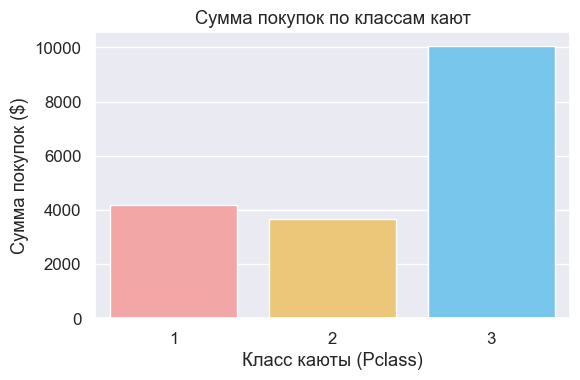

In [139]:
plt.figure(figsize=(6,4))
sns.barplot(
    x='Pclass',
    y='total_spent',
    data=df_class_spend,
    palette=['#FF9999', '#FFCC66', '#66CCFF']  # 1й, 2й, 3й класс
)
plt.title("Сумма покупок по классам кают")
plt.xlabel("Класс каюты (Pclass)")
plt.ylabel("Сумма покупок ($)")

plt.tight_layout()
plt.show()

In [143]:
query = """--Общее окличестов назначеннных в шлюпку и не назначенных
select
case
when l."PassengerId" is null then 'not_assigned'
else 'assigned'
end as lifeboat_status,
count(*) as passengers
from titanic.titanic t
left join titanic.lifeboat_assignments l
    on t."PassengerId" = l."PassengerId"
group by lifeboat_status;
"""
df_lifeboat = pd.read_sql_query(query, conn)
df_lifeboat

C:\Users\Акылай\AppData\Local\Temp\ipykernel_18660\2615691581.py:13: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_lifeboat = pd.read_sql_query(query, conn)


,lifeboat_status,passengers
0,assigned,298
1,not_assigned,593


C:\Users\Акылай\AppData\Local\Temp\ipykernel_18660\2369190687.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\Акылай\AppData\Local\Temp\ipykernel_18660\2369190687.py:18: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\Акылай\OneDrive\Desktop\my git\titanic\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


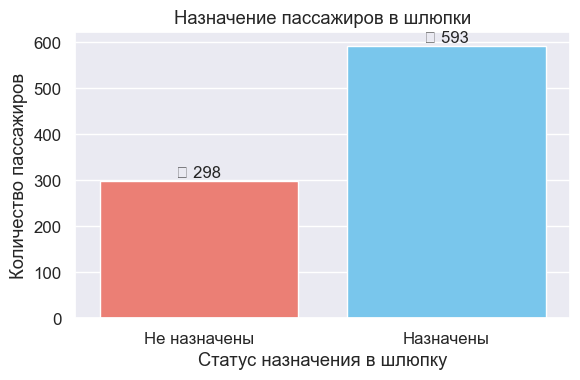

In [ ]:
plt.figure(figsize=(6,4))
sns.barplot(
    x='lifeboat_status',
    y='passengers',
    data=df_lifeboat,
    palette=['#FF6F61','#66CCFF']  # красный = не назначены, синий = назначены
    )

plt.title("Назначение пассажиров в шлюпки")
plt.xlabel("Статус назначения в шлюпку")
plt.ylabel("Количество пассажиров")

# Подписи над столбцами
for i, row in df_lifeboat.iterrows():
    plt.text(i, row['passengers'] + 1, f"{symbol} {row['passengers']}", ha='center', va='bottom', fontsize=12)

plt.xticks([0,1], ['Не назначены', 'Назначены'])
plt.tight_layout()
plt.show()